**INITIALIZATION:**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.

In [7]:
#@ INITIALIZATION:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**LIBRARIES AND DEPENDENCIES:**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [8]:
#@ INSTALLING DEPENDENCIES: UNCOMMENT BELOW: 
# !pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

In [9]:
#@ DOWNLOADING LIBRARIES AND DEPENDENCIES: 
from fastbook import *                                  # Getting all the Libraries. 
from fastai.callback.fp16 import *
from fastai.vision.all import *                         # Getting all the Libraries.

**GETTING THE DATA:**
- I will use **Imagenette** dataset here.

In [10]:
#@ GETTING THE DATASET: 
path = untar_data(URLs.IMAGENETTE_160)                  # Path to the Data. 
path.ls()                                               # Inspecting the Data.

(#4) [Path('/root/.fastai/data/imagenette2-160/.DS_Store'),Path('/root/.fastai/data/imagenette2-160/train'),Path('/root/.fastai/data/imagenette2-160/noisy_imagenette.csv'),Path('/root/.fastai/data/imagenette2-160/val')]

In [11]:
#@ GETTING IMAGE FILES: 
files = get_image_files(path)                           # Getting Image Files. 
files[0]                                                # Inspection. 

Path('/root/.fastai/data/imagenette2-160/train/n03417042/n03417042_19978.JPEG')

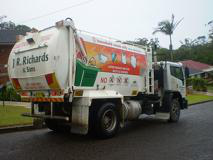

In [12]:
#@ INSEPCTING IMAGES: 
im = Image.open(files[0])                               # Initializing Image. 
im

In [13]:
#@ INSPECTING TENSORS OF IMAGES:
im_t = tensor(im)                                       # Converting into Tensors. 
im_t.shape                                              # Inspecting Tensors. 

torch.Size([160, 213, 3])

In [14]:
#@ GETTING UNIQUE FILES:
lbls = files.map(Self.parent.name()).unique(); lbls

(#10) ['n03417042','n02102040','n03445777','n03888257','n03425413','n02979186','n03394916','n03000684','n01440764','n03028079']

In [15]:
#@ CREATING VOCABULARY: 
v2i = lbls.val2idx(); v2i                               # Inspecting Vocabulary. 

{'n01440764': 8,
 'n02102040': 1,
 'n02979186': 5,
 'n03000684': 7,
 'n03028079': 9,
 'n03394916': 6,
 'n03417042': 0,
 'n03425413': 4,
 'n03445777': 2,
 'n03888257': 3}

**PREPARING DATASET:**

In [16]:
#@ DEFINING DATASET CLASS: 
class Dataset:                                                      # Defining Dataset Class. 
    def __init__(self, fns): self.fns = fns                         # Initializing Constructor Function. 
    def __len__(self): return len(self.fns)
    def __getitem__(self, i):
        im = Image.open(self.fns[i]).resize((64,64)).convert("RGB") # Getting Images.
        y = v2i[self.fns[i].parent.name]                            # Initializing Dependent Variable. 
        return tensor(im).float()/255, tensor(y)                    # Getting Tensors. 

In [17]:
#@ TRAINING AND VALIDATION FILENAMES: 
train_filt = L(o.parent.parent.name=="train" for o in files)        # Initializing Training Filters. 
train, valid = files[train_filt], files[~train_filt]                # Initializing Training and Validation Files. 
len(train), len(valid)                                              # Inspection. 

(9469, 3925)

In [18]:
#@ INITIALIZING DATASET: 
train_ds, valid_ds = Dataset(train), Dataset(valid)                 # Initializing Data Loaders. 
x, y = train_ds[0]                                                  # Getting a Dataset. 
x.shape, y                                                          # Inspection. 

(torch.Size([64, 64, 3]), tensor(0))

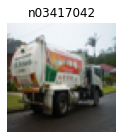

In [19]:
#@ INSPECTING A DATASET: 
show_image(x, title=lbls[y]);

In [20]:
#@ CREATING MINIBATCHES: 
def collate(idxs, ds):                                      # Defining Collate Function. 
    xb, yb = zip(*[ds[i] for i in idxs])
    return torch.stack(xb), torch.stack(yb)                 # Initializing Minibatches. 

#@ IMPLEMENTATION OF COLLATE FUNCTION: 
x, y = collate([1, 2], train_ds)                            # Initializing Collate Function. 
x.shape, y                                                  # Inspection. 

(torch.Size([2, 64, 64, 3]), tensor([0, 0]))

**INITIALIZING DATALOADER:**

In [21]:
#@ INITIALIZING DATALOADER: 
class DataLoader:                                                               # Defining Data Loader. 
    def __init__(self, ds, bs=128, shuffle=False, n_workers=1):                 # Initializing Constructor Function. 
        self.ds,self.bs,self.shuffle,self.n_workers = ds,bs,shuffle,n_workers   # Initializing Parameters. 
    
    def __len__(self): return (len(self.ds)-1) // self.bs+1

    def __iter__(self):
        idxs = L.range(self.ds)                                                 # Initializing Indexes. 
        if self.shuffle: idxs = idxs.shuffle()                                  # Initializing Shuffle. 
        chunks = [idxs[n:n+self.bs] for n in range(0,len(self.ds),self.bs)]     # Initializing Batches. 
        with ProcessPoolExecutor(self.n_workers) as ex:
            yield from ex.map(collate, chunks, ds=self.ds)                      # Preprocessing in Parallel. 

#@ IMPLEMENTATION OF DATALOADER: 
n_workers = min(16, defaults.cpus)
train_dl = DataLoader(train_ds, bs=128, shuffle=True, n_workers=n_workers)      # Initializing Training Data Loaders. 
valid_dl = DataLoader(valid_ds, bs=128, shuffle=False, n_workers=n_workers)     # Initializing Validation Data Loaders. 
xb, yb = first(train_dl)                                                        # Getting a Batch of Data. 
xb.shape, yb.shape, len(train_dl)                                               # Inspection. 

(torch.Size([128, 64, 64, 3]), torch.Size([128]), 74)

In [22]:
#@ INITIALIZING NORMALIZATION: 
stats = [xb.mean((0, 1, 2)), xb.std((0, 1, 2))]              # Initializing Image Statistics. 
class Normalize:                                             # Defining Normalization. 
    def __init__(self, stats): self.stats = stats            # Initializing Statistics. 

    def __call__(self, x):                                   # Initializing Callable Function. 
        if x.device != self.stats[0].device:
            self.stats = to_device(self.stats, x.device)
        return (x-self.stats[0]) / self.stats[1]

#@ IMPLEMENTATION OF NORMALIZATION: 
norm = Normalize(stats)                                      # Implementation of Function. 
def tfm_x(x):                                                # Defining Transformation Function. 
    return norm(x).permute((0,3,1,2))                        # Permutting Axis Order. 
t = tfm_x(x)                                                 # Implementation of Transformation. 
t.mean((0, 2, 3)), t.std((0, 2, 3))                          # Inspection. 

(tensor([-0.1717,  0.0370,  0.3813]), tensor([1.2179, 1.1552, 1.1164]))

**Note:**
- PIL uses HWC axis order while PyTorch uses NCHW axis order. 

In [23]:
#@ DEFINING PARAMETER:
class Parameter(Tensor):                                     # Defining Parameter. 
    def __new__(self, x): 
        return Tensor._make_subclass(Parameter, x, True)
    
    def __init__(self, *args, **kwargs):                     # Initializing Constructor Function. 
        self.requires_grad_()

#@ IMPLEMENTATION OF PARAMETER CLASS: 
Parameter(tensor(3.))                                        # Implementation.       

tensor(3., requires_grad=True)

In [24]:
#@ DEFINING MODULE: 
class Module:                                                # Defining Module. 
    def __init__(self):                                      # Initializing Constructor Function. 
        self.hook, self.params = None, []                    # Initialization. 
        self.children, self._training = [], False            # Initialization. 
    
    def register_parameters(self, *ps): self.params += ps    
    def register_modules(self, *ms): self.children += ms

    @property
    def training(self): return self._training
    @training.setter
    def training(self, v):
        self._training = v
        for m in self.children: m.training = v 

    def parameters(self):
        return self.params + sum([m.parameters() for m in self.children], [])
    
    def __setattr__(self, k, v):
        super().__setattr__(k, v)
        if isinstance(v, Parameter): self.register_parameters(v)
        if isinstance(v, Module): self.register_modules(v)

    def __call__(self, *args, **kwargs):
        res = self.forward(*args, **kwargs)
        if self.hook is not None: self.hook(res, args)
        return res
    
    def cuda(self):
        for p in self.parameters(): p.data = p.data.cuda()

In [25]:
#@ DEFINING MODULE: CONVLAYER: 
class ConvLayer(Module):                                                    # Defining Convolutional Layer. 
    def __init__(self, ni, nf, stride=1, bias=True, act=True):              # Initializing Constructor Function. 
        super().__init__()
        self.w = Parameter(torch.zeros(nf, ni, 3, 3))                       # Initializing Weights Parameter. 
        self.b = Parameter(torch.zeros(nf)) if bias else None               # Initializing Bias Parameter. 
        self.act, self.stride = act, stride                                 # Initialization. 
        init = nn.init.kaiming_normal_ if act else nn.init.xavier_normal_   # Initialization Kaiming Initializer.  
        init(self.w)                                                        # Initialization. 
    
    def forward(self, x):                                                   # Forward Propagation Function. 
        x = F.conv2d(x, self.w, self.b, stride=self.stride, padding=1)      # Implementation of Convolution. 
        if self.act: x = F.relu(x)                                          # Implementation of RELU. 
        return x

#@ IMPLEMENTATION OF MODULE: 
l = ConvLayer(3, 4)                                                         # Implementation. 
len(l.parameters())                                                         # Inspecting Parameters. 

2

In [26]:
#@ IMPLEMENTATION OF MODULE: 
xbt = tfm_x(xb)                                 # Implementation of Transformation. 
r = l(xbt)                                      # Implementation of Convolutional Layer. 
r.shape                                         # Inspection. 

torch.Size([128, 4, 64, 64])

In [27]:
#@ DEFINING MODULE: LINEAR MODEL: 
class Linear(Module):                                       # Defining Linear Model. 
    def __init__(self, ni, nf):                             # Initializing Constructor Function. 
        super().__init__()
        self.w = Parameter(torch.zeros(nf, ni))             # Initializing Weight Parameter. 
        self.b = Parameter(torch.zeros(nf))                 # Initializing Bias Parameter. 
        nn.init.xavier_normal_(self.w)                      # Initializing Xavier Initializer. 
    
    def forward(self, x):                                   # Forward Propagation Function. 
        return x@self.w.t() + self.b                        # Initializing Linear Model. 

#@ IMPLEMENTATION OF LINEAR MODEL: 
l = Linear(4, 2)                                            # Implementation of Linear Function. 
r = l(torch.ones(3, 4))                                     # Implementation.
r.shape                                                     # Inspection. 

torch.Size([3, 2])

In [28]:
#@ INITIALIZING TESTING MODULE: 
class T(Module):                                            # Defining Testing Module. 
    def __init__(self):                                     # Initializing Constructor Function. 
        super().__init__()                                  
        self.c, self.l = ConvLayer(3, 4), Linear(4, 2)      # Initializing Convolutional and Linear Layer. 

#@ INSPECTING TESTING MODULE: 
t = T()                                                     # Initializing Module. 
len(t.parameters())                                         # Inspecting Parameters. 

4

In [29]:
#@ PARAMETERS ON GPU: 
t.cuda()
t.l.w.device

device(type='cuda', index=0)

**CONVOLUTIONAL NEURAL NETWORKS:**

In [30]:
#@ INITIALIZING SEQUENTIAL MODULE: 
class Sequential(Module):                                   # Defining Sequential Module. 
    def __init__(self, *layers):                            # Initializing Constructor Function. 
        super().__init__()
        self.layers = layers                                # Initialization. 
        self.register_modules(*layers)
    
    def forward(self, x):                                   # Forward Propagation Function. 
        for l in self.layers: x = l(x)                      # Implementation of Layers. 
        return x 

In [31]:
#@ INITIALIZING ADAPTIVE POOLING MODULE: 
class AdaptivePool(Module):                                 # Defining Adaptive Pooling Module. 
    def forward(self, x): return x.mean((2, 3))             # Forward Propagation Function. 

#@ INITIALIZING CONVOLUTIONAL NEURAL NETWORKS:
def simple_cnn():                                           # Defining Convolutional Neural Networks. 
    return Sequential(                                      # Initializing Sequential Module. 
        ConvLayer(3, 16, stride=2),                         # Convolutional Layer: 32
        ConvLayer(16, 32, stride=2),                        # Convolutional Layer: 16
        ConvLayer(32, 64, stride=2),                        # Convolutional Layer: 8
        ConvLayer(64, 128, stride=2),                       # Convolutional Layer: 4
        AdaptivePool(),
        Linear(128, 10)
    )

#@ IMPLEMENTATION OF CONVOLUTIONAL NEURAL NETWORKS: 
m = simple_cnn()                                            # Initializing CNN Module. 
len(m.parameters())                                         # Inspecting Parameters. 

10

In [32]:
#@ IMPLEMENTATION OF HOOK:
def print_stats(outp, inp):                                 # Defining Function. 
    print(outp.mean().item(), outp.std().item())            # Getting Mean and Standard Deviation. 

for i in range(4):
    m.layers[i].hook = print_stats

#@ INSPECTION: 
r = m(xbt)                                                   # Implementation of CNN. 
r.shape

0.527184247970581 0.8703877925872803
0.43332064151763916 0.8272273540496826
0.43207114934921265 0.7533293962478638
0.46324652433395386 0.7388713955879211


torch.Size([128, 10])

**LOSS FUNCTION:**

In [33]:
#@ INITIALIZING NEGATIVE LOG LIKELIHOOD: 
def nll(input, target):                                         # Defining Loss Function. 
    return -input[range(target.shape[0]), target].mean()        # Calculating Loss. 

#@ INITIALIZING SOFTMAX FUNCTION: 
def log_softmax(x):                                             # Defining Softmax Function. 
    return (x.exp()/(x.exp().sum(-1, keepdim=True))).log()

#@ IMPLEMENTATION OF SOFTMAX FUNCTION: 
sm = log_softmax(r); sm[0][0]                                   # Inspection. 

tensor(-2.0625, grad_fn=<AliasBackward>)

In [34]:
#@ INITIALIZING CROSS ENTROPY FUNCTION: 
loss = nll(sm, yb); loss                                        # Inspecting Loss. 

tensor(2.6931, grad_fn=<AliasBackward>)

In [35]:
#@ INITIALIZING SOFTMAX FUNCTION: 
def log_softmax(x):                                             # Defining Softmax Function. 
    return x - x.exp().sum(-1, keepdim=True).log()

#@ IMPLEMENTATION OF SOFTMAX FUNCTION: 
sm = log_softmax(r); sm[0][0]                                   # Inspection. 

tensor(-2.0625, grad_fn=<AliasBackward>)

In [36]:
#@ INITIALIZING LOG OF SUM OF EXPONENTIALS: 
def logsumexp(x):                                               # Defining Function. 
    m = x.max(-1)[0]                                            # Getting Maximum. 
    return m + (x - m[:, None]).exp().sum(-1).log()

#@ IMPLEMENTATION: 
logsumexp(r)[0]

tensor(2.6985, grad_fn=<AliasBackward>)

In [37]:
#@ INITIALIZING SOFTMAX FUNCTION: 
def log_softmax(x): return x - x.logsumexp(-1, keepdim=True)   

#@ INITIALIZING CROSS ENTROPY LOSS FUNCTION: 
def cross_entropy(preds, yb):                                   # Defining Function. 
    return nll(log_softmax(preds), yb).mean()                   # Cross Entropy Loss Function. 

**INITIALIZING LEARNER:**

In [38]:
#@ INITIALIZING SGD OPTIMIZATION FUNCTION: 
class SGD:                                                      # Defining SGD Module.
    def __init__(self, params, lr, wd=0.):                      # Initializing Constructor Function. 
        store_attr(self, "params, lr, wd")
    
    def step(self):                                             # Defining Step Function. 
        for p in self.params: 
            p.data -= (p.grad.data + p.data*self.wd) * self.lr
            p.grad.data.zero_()                                 # Zeroing Gradients. 

#@ INITIALIZING DATA LOADER MODULE: 
class DataLoaders:                                              # Defining Data Loader Module.
    def __init__(self, *dls):                                   # Initializing Constructor Function. 
        self.train, self.valid = dls                            # Getting Training and Validation Datasets. 

#@ IMPLEMENTATION OF DATA LOADER MODULE: 
dls = DataLoaders(train_dl, valid_dl)                           # Initializing Data Loaders.

In [39]:
#@ INITIALIZING LEARNER: 
class Learner:                                                      # Defining Learner Module. 
    def __init__(self,model,dls,loss_func,lr,cbs,opt_func=SGD):     # Initializing Constructor Function. 
        store_attr(self, "model,dls,loss_func,lr,cbs,opt_func")
        for cb in cbs: cb.learner = self                            # Initializing Callbacks. 
    
    def one_batch(self):                                            # Defining Function. 
        self("before_batch")
        xb, yb = self.batch                                         # Initializing a Batch. 
        self.preds = self.model(xb)                                 # Getting Predictions. 
        self.loss = self.loss_func(self.preds, yb)                  # Getting Loss. 
        if self.model.training:                                     # Initializing Training Mode. 
            self.loss.backward()                                    # Initializing Back Propagation. 
            self.opt.step()                                         # Initializing Optimization of Loss. 
        self("after_batch")
    
    def one_epoch(self, train):                                     # Defining Function. 
        self.model.training = train                                 # Initializing Training Mode. 
        self("before_epoch")
        dl = self.dls.train if train else self.dls.valid            # Initializing Dataset. 
        for self.num,self.batch in enumerate(
            progress_bar(dl, leave=False)):
            self.one_batch()
        self("after_epoch")
    
    def fit(self, n_epochs):                                        # Defining Function. 
        self("before_fit")
        self.opt =self.opt_func(self.model.parameters(),self.lr)    # Implementation of Optimization Function. 
        self.n_epochs = n_epochs                                    # Initializing Epochs. 
        try:
            for self.epoch in range(n_epochs):
                self.one_epoch(True)
                self.one_epoch(False)
        except CancelFitException: pass
        self("after_fit")
    
    def __call__(self, name):                                       # Defining Callable Function. 
        for cb in self.cbs: getattr(cb, name, noop)()

#@ INITIALIZING CALLBACKS:
class Callback(GetAttr): _default = "learner"

class SetupLearnerCB(Callback):                                     # Defining Learner Callback. 
    def before_batch(self):                                         # Defining Function. 
        xb, yb = to_device(self.batch)                              # Initializing a Batch. 
        self.learner.batch = tfm_x(xb), yb                          # Initializing Transformations of Batches. 

    def before_fit(self): self.model.cuda()                         # Initializing GPU Parameters. 